In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import resnet
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
%matplotlib inline
def show(img, w=5, h=5):
    fig = plt.figure(figsize = (w,h))
    ax = fig.add_subplot(111)
    if len(img) == 3:
        ax.imshow(np.transpose(img.detach().numpy(), (1,2,0)), interpolation='nearest')
    else:
        ax.imshow(img.detach().numpy(), interpolation='nearest')
    plt.show()

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

class AlexNetVAE(nn.Module):
    def __init__(self):
        super(AlexNetVAE, self).__init__()
        #Encoding layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.mp1   = nn.MaxPool2d(kernel_size=3, stride=2,return_indices=True)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.mp2   = nn.MaxPool2d(kernel_size=3, stride=2,return_indices=True)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # self.mp5   = nn.MaxPool2d(kernel_size=3, stride=2,return_indices=True)

        #Bottleneck layers
        self.fc1 = nn.Linear(6400, 64)
        self.fc2 = nn.Linear(6400, 64)
        self.fc3 = nn.Linear(64, 6400)
        
        #Decoding layers
        # self.mu5     = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.deconv5 = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1)
        self.deconv4 = nn.ConvTranspose2d(256, 384, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(384, 192, kernel_size=3, padding=1)
        self.mu2     = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(192, 64, kernel_size=5, padding=2)
        self.mu1     = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose2d(64, 3, kernel_size=11, stride=4, padding=2, output_padding=1)
        
    def _encode(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x, self.mp1_index = self.mp1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x, self.mp2_index = self.mp2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        # x, self.mp5_index = self.mp5(x)
        return x.view(x.size(0), -1)
    
    def _decode(self, x):
        x = x.view(x.size(0), 256, 5, 5)
        # x = self.mu5(x, self.mp5_index, output_size=torch.Size([x.size(0), 256, 13, 13]))
        x = self.deconv5(x)
        x = F.relu(x)
        x = self.deconv4(x)
        x = F.relu(x)
        x = self.deconv3(x)
        x = F.relu(x)
        x = self.mu2(x, self.mp2_index, output_size=torch.Size([x.size(0), 192, 11, 11]))
        x = self.deconv2(x)
        x = F.relu(x)
        x = self.mu1(x, self.mp1_index, output_size=torch.Size([x.size(0), 64, 23, 23]))
        x = self.deconv1(x)
        return torch.sigmoid(x)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        h = self._encode(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self._decode(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [4]:
def _transform(resize, size):
    if not resize:
        return transforms.ToTensor()
    return transforms.Compose([
        transforms.Resize(size, 1),
        transforms.ToTensor()
        ])

def load_data(data_dir, batch_size, resize=False, size=224):
    """ Method returning a data loader for labeled data """
    # TODO (optional): add data transformations if needed
#     transform = transforms.ToTensor()
    data = datasets.ImageFolder(f'{data_dir}', transform=_transform(resize, size))
    data_loader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    return data_loader

In [ ]:
transform= lambda resize, size: _transform(resize, size)
transform(True, 224)

In [ ]:
train_loader = load_data('/scratch/drr342/dl/project/data/ssl_data_96/supervised/train', 64)
test_loader = load_data('/scratch/drr342/dl/project/data/ssl_data_96/supervised/val', 64)
unsup_loader = load_data('/scratch/drr342/dl/project/data/ssl_data_96/unsupervised', 64)
train_iter = train_loader.__iter__()
test_iter = test_loader.__iter__()
unsup_iter = unsup_loader.__iter__()

In [ ]:
N = 10
train_r = [None] * N
test_r = [None] * N
unsup_r = [None] * N
for i in range(N):
    train_img, _ = train_iter.next()
    test_img, _ = test_iter.next()
    unsup_img, _ = unsup_iter.next()
    train_r[i] = make_grid(train_img, nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
    test_r[i] = make_grid(test_img, nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
    unsup_r[i] = make_grid(unsup_img, nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)

In [ ]:
timeStamps = ['20190504_0625', '20190504_1006', '20190504_1401']
models = [AlexNetVAE()] * 3

for i in range(3):
    models[i] = nn.DataParallel(models[i])
    pretrained_model = torch.load(f=f'/scratch/drr342/dl/project/models/AlexNetVAE_{timeStamps[i]}.pth', map_location="cuda" if cuda else "cpu")
    models[i].load_state_dict(pretrained_model, strict=True)

In [ ]:
# unsup_img, _ = unsup_iter.next()
reconstruct = [None] * 3
mu = [None] * 3
logvar = [None] * 3
for i in range(3):
    models[i].eval()
    with torch.no_grad():
        reconstruct[i], mu[i], logvar[i] = models[i](unsup_img)

In [ ]:
def loss_function(recon_x, x, mu, logvar, batch_idx=0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    beta = 1#(batch_idx + 1) / len(train_loader)
    return BCE + beta * KLD

In [ ]:
for i in range(3):
    print(loss_function(reconstruct[i], unsup_img, mu[i], logvar[i]))

In [ ]:
show(unsup_img[0])
show(reconstruct[0])
show(reconstruct2[0])
show(reconstruct3[0])

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

model = Model().eval()

In [ ]:
img, _ = train_iter.next()

In [ ]:
N = 5
conv = [None] * N
with torch.no_grad():
    for i, (batch, lbl) in enumerate(train_loader):
        if i == N:
            break
        conv[i] = (model(img), i)

In [ ]:
for c, i in conv:
    print(c.shape, i)

In [ ]:
from torchvision import models

In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
img = train_iter.next()

In [ ]:
img[0].shape

In [ ]:
model.forward

In [ ]:
class ResNetVAE(nn.Module):
    def __init__(self):
        super(ResNetVAE, self).__init__()
        self.resnet = models.resnet34()
        self.layer4_deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
        )
    
    def encoder(self, x):
        # [N, 3, 96, 96]
        x = self.resnet.conv1(x)
        # [N, 64, 48, 48]
        x = self.resnet.bn1(x)
        # [N, 64, 48, 48]
        x = self.resnet.relu(x)
        # [N, 64, 48, 48]
        x = self.resnet.layer1(x)
        # [N, 64, 48, 48]
        x = self.resnet.layer2(x)
        # [N, 128, 24, 24]
        x = self.resnet.layer3(x)
        # [N, 256, 12, 12]
        x = self.resnet.layer4(x)
        # [N, 512, 6, 6]
        return x
    
#     def decoder(self, x):
        
    
    def forward(self, x):
        return self._encode(x)

In [ ]:
vae = ResNetVAE()

In [ ]:
fwd = vae(img_96[0])

In [ ]:
fwd.shape

In [ ]:
show(fwd[0][511])

In [5]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def deconv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1, output_padding=0):
    """3x3 deconvolution with padding"""
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation, output_padding=output_padding)

def deconv1x1(in_planes, out_planes, stride=1, output_padding=0):
    """1x1 deconvolution"""
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                              bias=False, output_padding=output_padding)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, mode, inplanes, planes, stride=1, resample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, output_padding=0):
        super(BasicBlock, self).__init__()
        if mode not in('conv', 'deconv'):
            raise ValueError('BasickBlock mode can only be conv or deconv')
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        if mode == 'conv':
            self.conv1 = conv3x3(inplanes, planes, stride)
            self.conv2 = conv3x3(planes, planes)
            self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        else:
            self.conv1 = deconv3x3(inplanes, planes, stride, output_padding=output_padding)
            self.conv2 = deconv3x3(planes, planes)
            self.relu = nn.ReLU(inplace=True)
        self.bn1 = norm_layer(planes)
        self.bn2 = norm_layer(planes)
        self.resample = resample
        self.stride = stride

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.resample is not None:
            identity = self.resample(x)
        
        out += identity
        out = self.relu(out)
        return out

In [6]:
class ResNetVAE(nn.Module):

    def __init__(self, layers, groups=1, width_per_group=64):
                 
        super(ResNetVAE, self).__init__()
        self._norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer('conv', 64, layers[0])
        self.layer2 = self._make_layer('conv', 128, layers[1], stride=2)               
        self.layer3 = self._make_layer('conv', 256, layers[2], stride=2)
        self.layer4 = self._make_layer('conv', 512, layers[3], stride=2)
        
        self.fc1 = nn.Linear(18432, 512)
        self.fc2 = nn.Linear(18432, 512)
        self.fc3 = nn.Linear(512, 18432)
        
        self.decon4 = self._make_layer('deconv', 512, layers[3], stride=2, output_padding=1)
        self.decon3 = self._make_layer('deconv', 256, layers[2], stride=2, output_padding=1)
        self.decon2 = self._make_layer('deconv', 128, layers[1], stride=2, output_padding=1)
        self.decon1 = self._make_layer('deconv', 64, layers[0], output_padding=0)
        
        self.decon0 = nn.ConvTranspose2d(self.inplanes, 3, kernel_size=7, stride=2, padding=3,
                               bias=False, output_padding=1)
        self.bn0 = self._norm_layer(3)
        self.sigmoid = nn.Sigmoid()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, mode, planes, blocks, stride=1, output_padding=0):
        norm_layer = self._norm_layer
        resample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes * BasicBlock.expansion:
            if mode == 'conv':
                resample = nn.Sequential(
                    conv1x1(self.inplanes, planes * BasicBlock.expansion, stride),
                    norm_layer(planes * BasicBlock.expansion),
                )
            else:
                resample = nn.Sequential(
                    deconv1x1(self.inplanes, planes * BasicBlock.expansion, stride, output_padding=output_padding),
                    norm_layer(planes * BasicBlock.expansion),
                )

        layers = []
        layers.append(BasicBlock(mode, self.inplanes, planes, stride, resample, self.groups,
                            self.base_width, previous_dilation, norm_layer, output_padding=output_padding))
        self.inplanes = planes * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(mode, self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
    
    def _encode(self, x):
        # [N, 3, 96, 96]
        x = self.conv1(x)
        # [N, 64, 48, 48]
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        # [N, 64, 48, 48]
        x = self.layer2(x)
        # [N, 128, 24, 24]
        x = self.layer3(x)
        # [N, 256, 12, 12]
        x = self.layer4(x)
        # [N, 512, 6, 6]
        
        return x.view(x.size(0), -1)
    
    def _decode(self, x):
        # [N, 18432]
        x = x.view(x.size(0), 512, 6, 6)
        x = self.decon4(x)
        # [N, 512, 12, 12]
        x = self.decon3(x)
        # [N, 256, 24, 24]
        x = self.decon2(x)
        # [N, 128, 48, 48]
        x = self.decon1(x)
        # [N, 64, 48, 48]
        
        x = self.decon0(x)
        # [N, 3, 96, 96]
        x = self.bn0(x)
#         x = self.sigmoid(x)
        return x

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        h = self._encode(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self._decode(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
        

In [7]:
iter_96 = iter(load_data('/scratch/drr342/dl/project/data/ssl_data_96/supervised/train', 64))
iter_224 = iter(load_data('/scratch/drr342/dl/project/data/ssl_data_96/supervised/train', 64, resize=True))

In [8]:
img_96 = iter_96.next()
img_224 = iter_224.next()

In [9]:
model_1Epoch = nn.DataParallel(ResNetVAE([2, 2, 2, 2]))
checkpoint = torch.load('/scratch/drr342/dl/project/models/ResNetVAE_20190506_0008.pth', map_location='cpu')
model_1Epoch.load_state_dict(checkpoint['model_state_dict'], strict=True)

In [10]:
fwd_1Epoch = model_1Epoch(img_96[0])

In [11]:
model_2Epoch = nn.DataParallel(ResNetVAE([2, 2, 2, 2]))
checkpoint_2Epoch = torch.load('/scratch/drr342/dl/project/models/ResNetVAE_20190506_0445.pth', map_location='cpu')
model_2Epoch.load_state_dict(checkpoint['model_state_dict'], strict=True)

In [12]:
fwd_2Epoch = model_2Epoch(img_96[0])

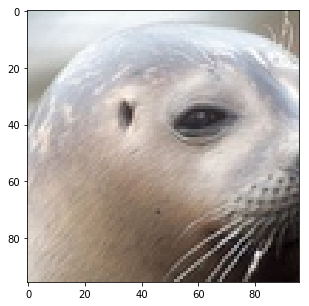

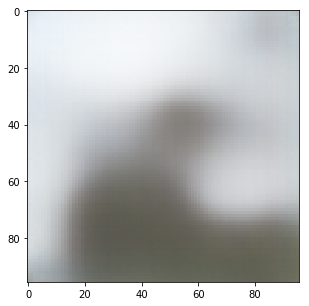

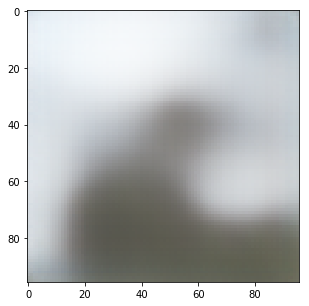

In [15]:
show(img_96[0][0])
show(nn.Sigmoid()(fwd_1Epoch[0][0]))
show(nn.Sigmoid()(fwd_2Epoch[0][0]))